In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [2]:
# Load wrangled data saved in .csv files for scheduling experiment sessions with HOMBRE scheduler
sch_sessions = pd.read_csv('data/scheduler/sessions.csv', index_col=0)
sch_pilots = pd.read_csv('data/scheduler/pilots.csv', index_col=0)
sch_units = pd.read_csv('data/scheduler/units.csv', index_col=0)

# Load wrangled data saved in .csv files for scheduling experiment sessions with general purpose scheduler
sws_sessions = pd.read_csv('data/synapse/weak_scaling/sessions.csv', index_col=0)
sws_pilots = pd.read_csv('data/synapse/weak_scaling/pilots.csv', index_col=0)
sws_units = pd.read_csv('data/synapse/weak_scaling/units.csv', index_col=0)

In [3]:
print 'Scheduler: Total number of experiments: %s' % sch_sessions['experiment'].shape[0]
print 'Scheduler: Total number of successful runs: %s' % sch_sessions.shape[0]
print 'Scheduler: Total number of pilots: %s' % sch_pilots.shape[0]
print 'Scheduler: Total number of units: %s\n' % sch_units.shape[0]

Scheduler: Total number of experiments: 3
Scheduler: Total number of successful runs: 3
Scheduler: Total number of pilots: 3
Scheduler: Total number of units: 2560



In [4]:
sch = sch_sessions[
    ['experiment',
     'nunit',
     'TTC',
     'P_LRMS_QUEUING',
     'U_AGENT_QUEUING',
     'U_AGENT_SCHEDULING',
     'U_AGENT_QUEUING_EXEC',
     'U_AGENT_EXECUTING']
        ].groupby(['experiment','nunit']).agg(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

# Rename columns for readibility
sch.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sch.rename(index={i[1]: '%s/%s' % (i[1], i[1]*32) for i in sch.index.get_values()}, inplace=True, level=1)
sch

TTQ     Agent queueing     Agent queueing execution            TTX               TTC     Agent scheduling    
                             mean std           mean std                     mean std       mean std          mean std             mean std
experiment nunit                                                                                                                           
exp1       256/8192    23676.0705 NaN        11.0161 NaN                 4.835300 NaN  1316.2753 NaN  2.507315e+04 NaN         3.176800 NaN
exp2       256/8192     1022.3516 NaN        13.9417 NaN                 0.515802 NaN  1053.3465 NaN  1.540692e+09 NaN         4.412299 NaN
exp3       2048/65536   8623.3539 NaN       124.2952 NaN                61.680899 NaN  1342.4023 NaN  1.540699e+09 NaN        99.525200 NaN

In [5]:
sws = sws_sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

sws.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sws.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sws.rename(index={i: '%s/%s' % (i, i*32) for i in sws.index.get_values()}, inplace=True)
sws

TTQ                Agent queueing            Agent queueing execution                   TTX                      TTC                Agent scheduling           
                     mean            std           mean        std                     mean       std        mean        std          mean            std             mean        std
nunit                                                                                                                                                                                
32/1024         376.16170     454.020819        0.33265   0.011526                  0.56305  0.006435   902.61050   3.436115    1465.59710     582.834886         0.289950   0.009404
64/2048         953.80485    1258.183734        0.82940   0.044406                  1.15940  0.015132   940.12655   0.003606    2078.31445    1378.665820         0.722000   0.029698
128/4096       1482.38230    1361.444446        1.93360   0.060953                  2.97690  0.231082   922.77575   3.545363    2517.79720    1361.391413         1.739001   0.057415
256/8192      15661.73065     215.109873        5.37200   0.008910                 14.34745  2.186444   978.65000  17.178594   16830.68410      89.708375         4.955049   0.012231
512/16384    138008.15775  194402.885826        9.68035   0.453468                 59.99210  5.236267  1019.28595  24.826590  139239.01575  194520.955971         8.648402   0.302925
1024/32768   180526.21985  139177.620083       49.39715  16.769815                153.19430  0.100551  1157.04735  10.245765  181895.86550  139303.904051        45.577102  15.803693
2048/65536    34266.92055   23284.026668      242.52515   3.192941                369.11190  2.443760  1428.51745  36.404898   35887.34015   23360.466042       225.011101   5.062887
4096/131072  736775.60040            NaN      737.18650        NaN                907.90640       NaN  2143.19690        NaN  739242.68930            NaN       665.269003        NaN

In [6]:
# Durations units workload specific scheduler (HOMBRE)
data_sch = dict()
sch_path = '../rawdata/scheduling/'
sources_sch = ['%s/rp.session.titan-ext1.merzky1.017832.0006' % sch_path,
               '%s/rp.session.titan-ext1.merzky1.017832.0007' % sch_path]
data_sch = get_unit_durations(data_sch, sources_sch)

# Durations units general purpose scheduler
data_sws = dict()
sws_path = '../rawdata/weak_scaling_synapse_titan/optimized'
sources_sws = ['%s/ws_syn_titan_2048_32_65536_60_7.0' % sws_path,
               '%s/ws_syn_titan_2048_32_65536_60_7.1' % sws_path,
               '%s/ws_syn_titan_256_32_8192_60_4.0'   % sws_path,
               '%s/ws_syn_titan_256_32_8192_60_4.1'   % sws_path]
data_sws = get_unit_durations(data_sws, sources_sws)

conflicting time sync for bootstrap_0.prof                              (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.04 -      -4.77 =  4.73
conflicting time sync for agent_0.staging.input.0.prof                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.01 -      -4.77 =  4.76
conflicting time sync for agent_0.staging.output.0.prof                 (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -      -4.77 =  4.75
conflicting time sync for agent_0.staging.input.0.child.prof            (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -      -4.77 =  4.75
conflicting time sync for update.0.child.prof                           (titan-batch3.ccs.ornl.gov:10.128.36.164):    

/Users/mturilli/Virtualenvs/experiments/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


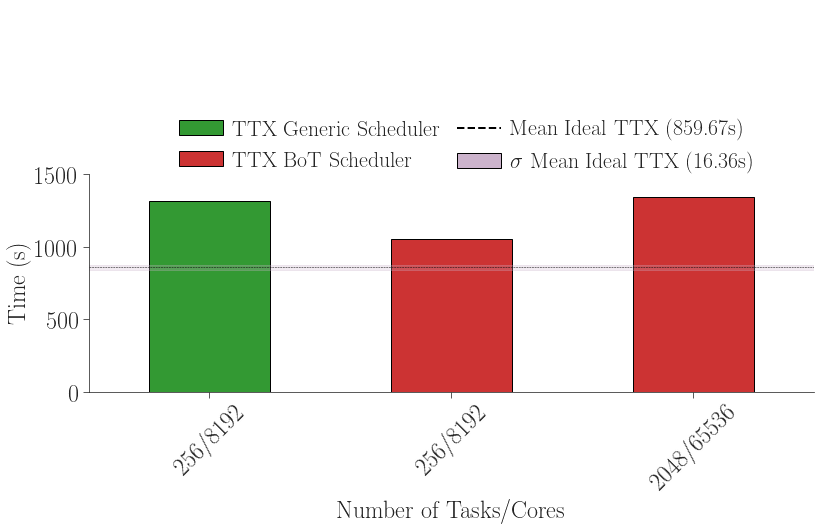

In [7]:
fig, ax = fig_setup(figsize=(13,4))

# sch[sch.index.isin(['exp1'], level='experiment')]['TTX'].reset_index().plot.bar(
#         x='nunit', y='mean', yerr='std', 
#         width=0.5, color=tableau20[4], ax=ax, rot=45, legend=False)

ax1 = sch['TTX'].reset_index().plot.bar(
        x='nunit', y='mean', yerr='std', 
        width=0.5, color=[tableau20[4], tableau20[6],tableau20[6]], ax=ax, rot=45, legend=False)

data_mean = np.mean(data_sch['exec-app'])
data_sigma = np.sqrt(np.var(data_sch['exec-app']))
ax1.axhline(y=np.mean(data_sch['exec-app']), lw=0.5, color='black', ls='dashed')
ax1.axhspan(data_mean-data_sigma, data_mean+data_sigma, alpha=0.25, color=tableau20[9])

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,1500)
ax.set_xlim(-0.5)

fig.legend(
            (mpl.patches.Patch(facecolor=tableau20[4]),
             mpl.patches.Patch(facecolor=tableau20[6]),
             mpl.lines.Line2D([], [], color='black', linestyle='dashed'),
             mpl.patches.Patch(facecolor=tableau20[9]),
            ),
            ('TTX Generic Scheduler', 
             'TTX BoT Scheduler', 
             'Mean Ideal TTX (%ss)' %  round(data_mean, 2),
             '$\sigma$ Mean Ideal TTX (%ss)' % round(data_sigma, 2)),
            'upper left',
            ncol=2,
            columnspacing=0.75,
            handletextpad=0.4,
            bbox_to_anchor=(0.17, 1.5)
          )

In [8]:
# Runs with general purpose scheduler and the hombre scheduler
hombre = sch[~sch.index.isin(['exp1'], level='experiment')]
hombre = hombre.set_index(hombre.index.get_level_values(1))
gpurpose = sws.loc[['256/8192','2048/65536']]
compare_sch = pd.concat([gpurpose,hombre], keys=['gpurpose', 'hombre',])
compare_sch

TTQ               Agent queueing           Agent queueing execution                   TTX                      TTC               Agent scheduling          
                            mean           std           mean       std                     mean       std        mean        std          mean           std             mean       std
         nunit                                                                                                                                                                          
gpurpose 256/8192    15661.73065    215.109873        5.37200  0.008910                14.347450  2.186444   978.65000  17.178594  1.683068e+04     89.708375         4.955049  0.012231
         2048/65536  34266.92055  23284.026668      242.52515  3.192941               369.111900  2.443760  1428.51745  36.404898  3.588734e+04  23360.466042       225.011101  5.062887
hombre   256/8192     1022.35160           NaN       13.94170       NaN                 0.515802       NaN  1053.34650        NaN  1.540692e+09           NaN         4.412299       NaN
         2048/65536   8623.35390           NaN      124.29520       NaN                61.680899       NaN  1342.40230        NaN  1.540699e+09           NaN        99.525200       NaN

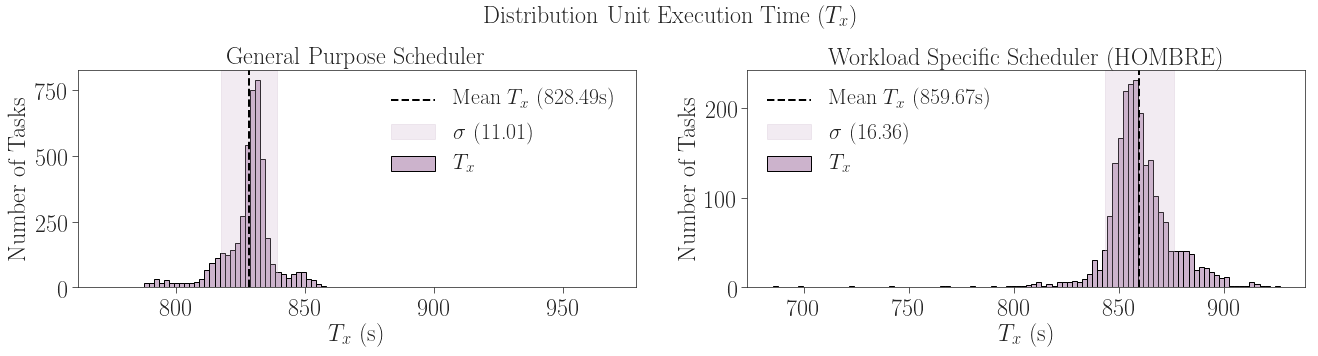

In [9]:
def plot_distribution_tx(data, ax, title):
    data_mean = np.mean(data['exec-app'])
    data_sigma = np.sqrt(np.var(data['exec-app']))

    ax.hist(data['exec-app'], bins=100, color=tableau20[9])#, histtype='step')
    ax.axvline(x=data_mean, color='black', linestyle='dashed')
    ax.axvspan(data_mean-data_sigma, data_mean+data_sigma, alpha=0.25, color=tableau20[9])

    ax.set_title(title)
    ax.set_xlabel('$T_x$ (s)')
    ax.set_ylabel('Number of Tasks')
    ax.legend(['Mean $T_x$ (%ss)' % round(data_mean, 2), 
               '$\sigma$ (%s)' % round(data_sigma, 2), 
               '$T_x$'])

fig = plt.figure(figsize=(22,4))
fig.tight_layout() 
fig.suptitle('Distribution Unit Execution Time ($T_x$)', y=1.1)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_distribution_tx(data_sws, ax1, 'General Purpose Scheduler')
plot_distribution_tx(data_sch, ax2, 'Workload Specific Scheduler (HOMBRE)')

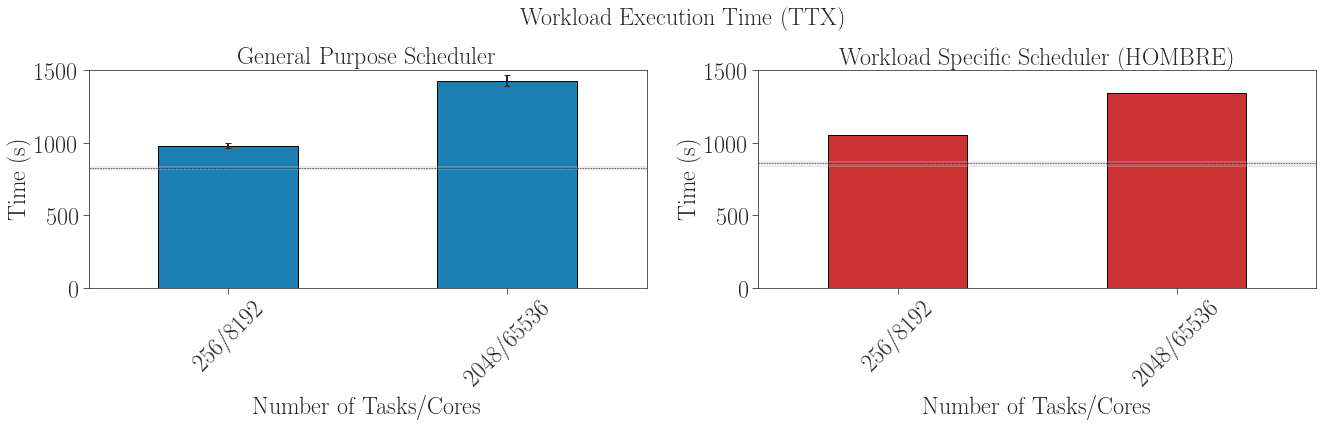

In [10]:
def plot_weak_scaling(df, data, ax, color, title):
    data_mean = np.mean(data['exec-app'])
    data_sigma = np.sqrt(np.var(data['exec-app']))

    df['TTX'].reset_index().plot.bar(
        x='nunit', y='mean', yerr='std', 
        width=0.5, color=[color], rot=45, legend=False,
        ax=ax)

    ax.axhline(y=np.mean(data['exec-app']), lw=0.5, color='black', ls='dashed')
    ax.axhspan(data_mean-data_sigma, data_mean+data_sigma, alpha=0.25, color=tableau20[9])

    ax.set_title(title)
    ax.set_xlabel('Number of Tasks/Cores')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0,1500)
    ax.set_xlim(-0.5)

fig = plt.figure(figsize=(22,4))
fig.tight_layout() 
fig.suptitle('Workload Execution Time (TTX)', y=1.1)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_weak_scaling(gpurpose, data_sws, ax1, tableau20[0], 'General Purpose Scheduler')
plot_weak_scaling(hombre, data_sch, ax2, tableau20[6], 'Workload Specific Scheduler (HOMBRE)')